# Libraries

In [2]:
import ast
import math
import os
import gc

import cv2
from pathlib import Path

from PIL import Image, ImageSequence
import numpy as np
from numpy.fft import fft2, fftshift, ifft2, ifftshift
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, argrelextrema
# from skfda import FDataGrid
from numpy import unravel_index
import statistics
import heapq
import pandas as pd

# import tensorflow as tf
# from tensorflow.keras import layers, models

import itertools

# Functions

## Smoothing

In [3]:
def moving_average(signal, window_size=5):
    return np.convolve(signal, np.ones(window_size) / window_size, mode='same')

In [4]:
def merge_peaks_by_distance(peaks, min_distance):
    merged_peaks = []
    i = 0
    while i < len(peaks) - 1:
        if abs(peaks[i] - peaks[i+1]) <= min_distance:
            merged_peak = (peaks[i] + peaks[i+1]) // 2
            merged_peaks.append(merged_peak)
            i += 2  
        else:
            merged_peaks.append(peaks[i])
            i += 1

    if i == len(peaks) - 1:
        merged_peaks.append(peaks[i])
    return merged_peaks


## Circle functions

In [5]:
def circle_radius_fun(peaks_x,peaks_y,ring_index,ccol,crow):
    # Adjusted peak selection to use closest peaks around ccol
    closest_peak_x = min(peaks_x, key=lambda x: abs(x-ccol))
    closest_peak_y = min(peaks_y, key=lambda y: abs(y-crow))

    # Using peak indices to find distances to closest peaks
    peak_index_x = peaks_x.tolist().index(closest_peak_x)
    peak_index_y = peaks_y.tolist().index(closest_peak_y)
    # peak_index_x=peaks_x.index(closest_peak_x)
    # peak_index_y=peaks_y.index(closest_peak_y)

    if peak_index_x > 0:
        rl_x = ccol - peaks_x[peak_index_x - ring_index]
        rr_x = peaks_x[peak_index_x + ring_index] - ccol

    if peak_index_y > 0:
        ru_y = crow - peaks_y[peak_index_y - ring_index]
        rl_y = peaks_y[peak_index_y + ring_index] - crow


    return round((rl_x + rr_x + ru_y + rl_y) / 4., 0)

In [6]:
def circle_change_limiter(circle_radius,prev_circle_radius,allowed_change,ring_index,peaks_x,peaks_y,ccol,crow):
    if prev_circle_radius is not None and circle_radius > prev_circle_radius * (1+allowed_change) and ring_index != 1:
        ring_index=ring_index-1
        # ccol=prev_ccol
        # crow=prev_crow
        print(f'{circle_radius} high')
        circle_radius=circle_radius_fun(peaks_x,peaks_y,ring_index,ccol,crow)
    elif prev_circle_radius is not None and circle_radius < prev_circle_radius * (1-allowed_change):
        print(prev_circle_radius * 1-allowed_change)
        ring_index=ring_index+1
        # ccol=prev_ccol
        # crow=prev_crow
        print('low')
        circle_radius=circle_radius_fun(peaks_x,peaks_y,ring_index,ccol,crow)
    return circle_radius,ring_index

In [7]:
def get_center_from_peaks(peaks, current_center):
    valid_peaks = [peak for peak in peaks if np.abs(peak - current_center) >= 10]
    left_peaks = np.array([peak for peak in valid_peaks if peak < current_center])
    right_peaks = np.array([peak for peak in valid_peaks if peak > current_center])

    if len(left_peaks) == 0 or len(right_peaks) == 0:
        return current_center, 0

    left_peak = left_peaks[-1] 
    right_peak = right_peaks[0] 

    refined_center = (left_peak + right_peak) // 2
    # print(f'current: {current_center}, left_peak: {left_peak}, right_peak: {right_peak}, refined center: {refined_center}\n {left_peaks} || {right_peaks}')

    distance_between_peaks = np.abs(right_peak - left_peak)

    return refined_center, distance_between_peaks

In [8]:
def adaptive_movement_threshold(prev_ccol, prev_crow, ccol, crow, prev_movement, allowed_change=5):
    # movement
    if prev_ccol != None and prev_crow!= None:
        distance = np.linalg.norm([ccol - prev_ccol, crow - prev_crow])
        print(distance)
        
        # if the center moves in the video, increase allowance
        if distance > prev_movement:
            allowed_change = min(distance, allowed_change * 2)
        
        # Allow movement if it is within the allowed range
        if distance <= allowed_change:
            return ccol, crow, distance
        else:
            # Reject large shifts
            return prev_ccol, prev_crow, prev_movement
    else:
        return ccol,crow,prev_movement


In [9]:
def get_center_from_minimums(minimums, current_center,min_depth=0.25):
    # Filter minimums based on a minimum distance from the current center (to avoid noise)
    valid_minimums = [minm for minm in minimums if np.abs(minm - current_center) >= 10]
    left_minimums = np.array([minm for minm in valid_minimums if minm < current_center])
    right_minimums = np.array([minm for minm in valid_minimums if minm > current_center])

    # Ensure there are valid minimums on both sides of the current center
    if len(left_minimums) == 0 or len(right_minimums) == 0:
        return current_center, 0

    # Take the second-to-last left minimum and second right minimum as references
    left_minimum = left_minimums[-2]  # Adjust indexing as needed
    right_minimum = right_minimums[1]  # Adjust indexing as needed

    # Compute the refined center based on the left and right minimums
    refined_center = (left_minimum + right_minimum) // 2
    # print(f'current: {current_center}, left_minimum: {left_minimum}, right_minimum: {right_minimum}, refined center: {refined_center}')

    # Compute the distance between the two reference minimums
    distance_between_minimums = np.abs(right_minimum - left_minimum)

    return refined_center, distance_between_minimums


In [10]:
def draw_circle(image,ccol,crow,circle_radius):
    cross_length=10

    circle_img = cv2.circle(image.copy(), (ccol, crow), int(circle_radius), (255, 0, 0), 2)
    cv2.line(circle_img,(ccol - cross_length, crow), (ccol + cross_length, crow), (255, 255, 255), 1)
    cv2.line(circle_img, (ccol, crow - cross_length), (ccol, crow + cross_length), (255, 255, 255), 1)
    
    return circle_img

## Image extraction and exploration

In [11]:
def image_background_brightness(image):
        top_left = image[0:5, 0:5]
        top_right = image[0:5, -5:]
        bottom_left = image[-5:, 0:5]
        bottom_right = image[-5:, -5:]
        brightness = np.concatenate((top_left.flatten(), top_right.flatten(), 
                                  bottom_left.flatten(), bottom_right.flatten()))
        # brightness=top_left+top_right+bottom_left+bottom_right

        return [np.mean(brightness),np.median(brightness),statistics.mode(brightness)]

In [12]:
def tiff_to_png(input_tiff, input_path, output_path):
    try:
        sq = Image.open(os.path.join(input_path, input_tiff))
        for i, img in enumerate(ImageSequence.Iterator(sq)):
            output = os.path.join(output_path, f"frame_{i:06d}.png")
            img.save(output)
    finally:
        # print("PNG extraction done")
        sq.close()

In [13]:
def get_first_png(input_tiff, input_path):
    try:
        sq = Image.open(os.path.join(input_path, input_tiff))
        first_frame = next(ImageSequence.Iterator(sq))
        first_frame_np = np.array(first_frame)
        if first_frame_np.ndim == 2:
            return first_frame_np
        else:
            return cv2.cvtColor(first_frame_np, cv2.COLOR_RGB2GRAY)
    finally:
        # print("PNG extraction done")
        sq.close()

In [14]:
def pad_image(image, target_size=(512, 512), padding_value=0):
    old_height, old_width = image.shape

    # Padding sizes
    top_pad = (target_size[0] - old_height) // 2
    bottom_pad = target_size[0] - old_height - top_pad
    left_pad = (target_size[1] - old_width) // 2
    right_pad = target_size[1] - old_width - left_pad

    padded_image = np.pad(image, ((top_pad, bottom_pad), (left_pad, right_pad)), mode='constant', constant_values=padding_value)

    return padded_image

# main code

In [15]:
def ring_search(r_in,r_out,ring_index,allowed_change,input_path,input_tiff,output_base_path):
    # autoencoder = tf.keras.models.load_model('autoencoder_model_256.h5')


    #  For guarding against index changes
    prev_circle=None
    prev_circle_radius=None
    prev_ccol=None
    prev_crow=None
    prev_movement=0
    cross_length = 10 #Center cross
    ring_index_start=ring_index

    output_path = Path(output_base_path) / Path(input_tiff).stem
    output_path.mkdir(parents=True, exist_ok=True)
    tiff_to_png(input_tiff, input_path, output_path)
    test_number=input_tiff.split('.')[0]
    # print(test_number)

    result_folder = f"Results_Validation/{test_number}/" + Path(input_tiff).stem + f"_Results_bw{r_in}{r_out}_{ring_index}"
    # print(result_folder)
    Path(result_folder).mkdir(parents=True, exist_ok=True)

    error_log = []

    df = pd.DataFrame(columns=['center_y(ccol)', 'center_x(crow)', 'circle_radius'])

    for filename in os.listdir(output_path):
        file_path = os.path.join(output_path, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        brightness=image_background_brightness(image)
        # image=pad_image(image=image,padding_value=brightness[0])
        imageBright = cv2.convertScaleAbs(image,10,1.5)
        # imageBright=image
        # fig, axes = plt.subplots(2, 3, figsize=(15, 10)) #Orig
        fig, axes = plt.subplots(2, 4, figsize=(15, 10))
        axes = axes.ravel()

        axes[0].imshow(imageBright, cmap='gray', vmin=0, vmax=255)
        axes[0].set_title('Original Image')

        ftimage = fft2(imageBright)
        ftimage = fftshift(ftimage)
        axes[1].imshow(20 * np.log(np.abs(ftimage) + 1), cmap='gray', vmin=0, vmax=255)
        axes[1].set_title('Fourier Transform')

        rows, cols = ftimage.shape
        crow, ccol = rows // 2, cols // 2
        mask = np.zeros((rows, cols), dtype=np.uint8)

        x, y = np.ogrid[:rows, :cols]
        mask_area = np.logical_and(((x - crow)**2 + (y - ccol)**2 >= r_in**2),
                                ((x - crow)**2 + (y - ccol)**2 <= r_out**2))
        mask[mask_area] = 1
        axes[2].imshow(mask, cmap='gray')
        axes[2].set_title('Bandpass Filter')

        m_app_ftimage = ftimage * mask
        i_ftimage = ifftshift(m_app_ftimage)
        result_img = ifft2(i_ftimage)
        tmp = np.log(np.abs(result_img) + 1)
        axes[3].imshow(tmp, cmap='gray', vmin=tmp.min(), vmax=tmp.max())
        axes[3].set_title('Filtered Image')

        axes[4].plot(tmp[int(tmp.shape[0]/2), :], color='blue')
        axes[4].set_title('Intensity Profile')

        # crow, ccol = unravel_index(tmp.argmax(), tmp.shape)
        crow, ccol = unravel_index(tmp.argmax(), result_img.shape)
        
        
        central_line_y = tmp[crow, :]
        central_line_x = tmp[:, ccol]

        smoothed_central_line_y = moving_average(central_line_y, window_size=4)
        smoothed_central_line_x = moving_average(central_line_x, window_size=4)

        peaks_y = argrelextrema(smoothed_central_line_y, np.greater)[0]
        peaks_x = argrelextrema(smoothed_central_line_x, np.greater)[0]
        
        minimums_y = argrelextrema(smoothed_central_line_y, np.less)[0]
        minimums_x = argrelextrema(smoothed_central_line_x, np.less)[0]

        # peaks_x=np.array(merge_peaks_by_distance(peaks_x,30))
        # peaks_y=np.array(merge_peaks_by_distance(peaks_y,30))

        if len(peaks_x) > 1 and len(peaks_y) > 1:
            ccol, x_distance = get_center_from_peaks(peaks_y, ccol)
            crow, y_distance = get_center_from_peaks(peaks_x, crow)
            # ccol, x_distance = get_center_from_minimums(minimums_y, ccol)
            # crow, y_distance = get_center_from_minimums(minimums_x, crow)
            # print(f'{ccol} {crow}')
            circle_radius = circle_radius_fun(peaks_x,peaks_y,ring_index,ccol,crow)
            

            circle_radius,ring_index=circle_change_limiter(circle_radius,prev_circle_radius,allowed_change,ring_index,peaks_x,peaks_y,ccol,crow)
                
            circle_img = cv2.circle(image.copy(), (ccol, crow), int(circle_radius), (255, 0, 0), 2)
            # circle_img = cv2.circle(denoised_image.copy(), (ccol, crow), int(circle_radius), (255, 0, 0), 2)
            cv2.line(circle_img,(ccol - cross_length, crow), (ccol + cross_length, crow), (255, 255, 255), 1)
            cv2.line(circle_img, (ccol, crow - cross_length), (ccol, crow + cross_length), (255, 255, 255), 1)
            # circle_img=pad_image(image=circle_img,padding_value=brightness[0])
            axes[5].imshow(circle_img, cmap='gray', vmin=0, vmax=255)
            axes[5].set_title('Result with Circle')
        else:
            error_log.append([filename, 'Frame with no valid peaks', r_in, r_out, 2])
            axes[5].imshow(image, cmap='gray', vmin=0, vmax=255)
            axes[5].set_title('Result with Circle (No valid peaks)')

        # Plot intensity profiles and highlight peaks
        axes[6].plot(smoothed_central_line_y, color='blue')
        for peak in peaks_y:
            axes[6].axvline(x=peak, color='red', linestyle='--')  # Mark peaks with red dashed lines
        axes[6].set_title('Intensity Profile (Y-Axis) with Peaks')

        axes[7].plot(smoothed_central_line_x, color='green')
        for peak in peaks_x:
            axes[7].axvline(x=peak, color='red', linestyle='--')  # Mark peaks with red dashed lines
        axes[7].set_title('Intensity Profile (X-Axis) with Peaks')

        prev_circle_radius=circle_radius
        prev_ccol=ccol
        prev_crow=crow

        df_append= pd.DataFrame(columns=['center_y(ccol)','center_x(crow)','circle_radius'])
        new_data={'center_y(ccol)':ccol,'center_x(crow)':crow,'circle_radius':circle_radius}
        df = pd.concat([df, pd.DataFrame([new_data])], ignore_index=True)
        plt.tight_layout()

        filename=filename+f'brigtness_med-{brightness[0]}_brightness_avg-{brightness[1]}'
        df.to_excel(f"Excels/Video{test_number}_{r_in}{r_out}_{ring_index_start}.xlsx")

        # plt.savefig(os.path.join(result_folder, f"composite_{filename}.png"))
        # plt.show()
        plt.clf()
        plt.cla()
        plt.close('all')
        del image
        gc.collect()
        # print(circle_radius)
    # df.to_excel(f"Video{test_number}_{r_in}{r_out}_{ring_index}_brightened.xlsx")
    # print("All images processed and saved in the results folder.")

In [16]:
def post_processing(r_in,r_out,ring_index,allowed_change,input_path,input_tiff,output_base_path):
    movement_threshold=20 #Sum of all center movements in a video
    cross_length = 10 #Center cross
    ring_index_start=ring_index

    output_path = Path(output_base_path) / Path(input_tiff).stem
    output_path.mkdir(parents=True, exist_ok=True)
    test_number=input_tiff.split('.')[0]

    result_folder = f"Results_Validation/{test_number}/" + Path(input_tiff).stem + f"_Results_bw{r_in}{r_out}_{ring_index}"

    preProcData=pd.read_excel(f'Excels/Video{test_number}_{r_in}{r_out}_{ring_index_start}.xlsx')

    # calculating the sum of differences of the center (moving bead or stationary)
    preProcData['diff_center_y'] = preProcData['center_y(ccol)'].diff().abs().fillna(0)
    preProcData['diff_center_x'] = preProcData['center_x(crow)'].diff().abs().fillna(0)
    # preProcData['total_movement'] = preProcData['diff_center_y'] + preProcData['diff_center_x']
    totalMovement=0
    for index, row in preProcData.iterrows():
        totalMovement=totalMovement+row['diff_center_x']+row['diff_center_y']
    
    # .rolling(window=3)
    if(totalMovement<movement_threshold):
        preProcData['smooth_center_y(ccol)'] = preProcData['center_y(ccol)'].rolling(window=3).mean()
        preProcData['smooth_center_x(crow)'] = preProcData['center_x(crow)'].rolling(window=3).mean()
        preProcData['smooth_radius'] = preProcData['circle_radius'].rolling(window=3).mean()  

        preProcData.fillna(method='bfill', inplace=True) # for the beginning

        i = 0
        for filename in os.listdir(output_path):
            file_path = os.path.join(output_path, filename)
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            ccol=int(preProcData['smooth_center_y(ccol)'][i])
            crow=int(preProcData['smooth_center_x(crow)'][i])
            circle_radius=int(preProcData['smooth_radius'][i])

            circle_img=draw_circle(image,ccol,crow,circle_radius)
            
            plt.imshow(circle_img, cmap='gray', vmin=0, vmax=255)
            plt.savefig(os.path.join(result_folder, f"result_{filename}.png"))
            # plt.show()
            i+=1

    else:
        i = 0
        for filename in os.listdir(output_path):
            file_path = os.path.join(output_path, filename)
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            preProcData['smooth_radius'] = preProcData['circle_radius'].rolling(window=3).mean()  
            preProcData.fillna(method='bfill', inplace=True)

            ccol=int(preProcData['center_y(ccol)'][i])
            crow=int(preProcData['center_x(crow)'][i])
            circle_radius=int(preProcData['smooth_radius'][i])

            circle_img=draw_circle(image,ccol,crow,circle_radius)
            
            plt.imshow(circle_img, cmap='gray', vmin=0, vmax=255)
            plt.savefig(os.path.join(result_folder, f"result_{filename}.png"))
            # plt.show()
            i+=1



    

# Grid Test

In [17]:
# test_values = ['7','8','9','10']
# # r_in_values = [3, 6]  # List of r_in values
# # r_out_values = [7, 9]  # List of r_out values
# r_vals=[[3,7],[6,9]]
# ring_index_values = [1, 2]  # List of ring_index values

# for test, r_val, ring_index in itertools.product(test_values, r_vals, ring_index_values):
#     try:
#         # Test each combination
#         params = {
#             'r_in': r_val[0],
#             'r_out': r_val[1],
#             'ring_index': ring_index,
#             'allowed_change': 0.2,
#             'input_path': 'Tiffs_Validation',
#             'input_tiff': f'Video{test}.tif',
#             'output_base_path': f'Results_Validation/Video{test}'
#         }
#         ring_search(**params)
#     except Exception as e:
#         print(f"Test failed for parameters: test={test}, r_in={r_val[0]}, r_out={r_val[1]}, ring_index={ring_index}")
#         print(f"Error: {e}")
#         continue

C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_32544\1687870287.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_data])], ignore_index=True)
C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_32544\3270579895.py:53: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True)
C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_32544\1687870287.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavio

Test failed for parameters: test=1, r_in=6, r_out=9, ring_index=1
Error: cannot access local variable 'ru_y' where it is not associated with a value
Test failed for parameters: test=1, r_in=6, r_out=9, ring_index=2
Error: index 15 is out of bounds for axis 0 with size 15


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_32544\1687870287.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_data])], ignore_index=True)
C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_32544\3270579895.py:53: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True)
C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_32544\1687870287.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavio

Test failed for parameters: test=9, r_in=3, r_out=7, ring_index=2
Error: index 7 is out of bounds for axis 0 with size 7


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_32544\1687870287.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_data])], ignore_index=True)
C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_32544\3270579895.py:53: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True)
C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_32544\1687870287.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavio

Test failed for parameters: test=10, r_in=6, r_out=9, ring_index=2
Error: index 11 is out of bounds for axis 0 with size 11


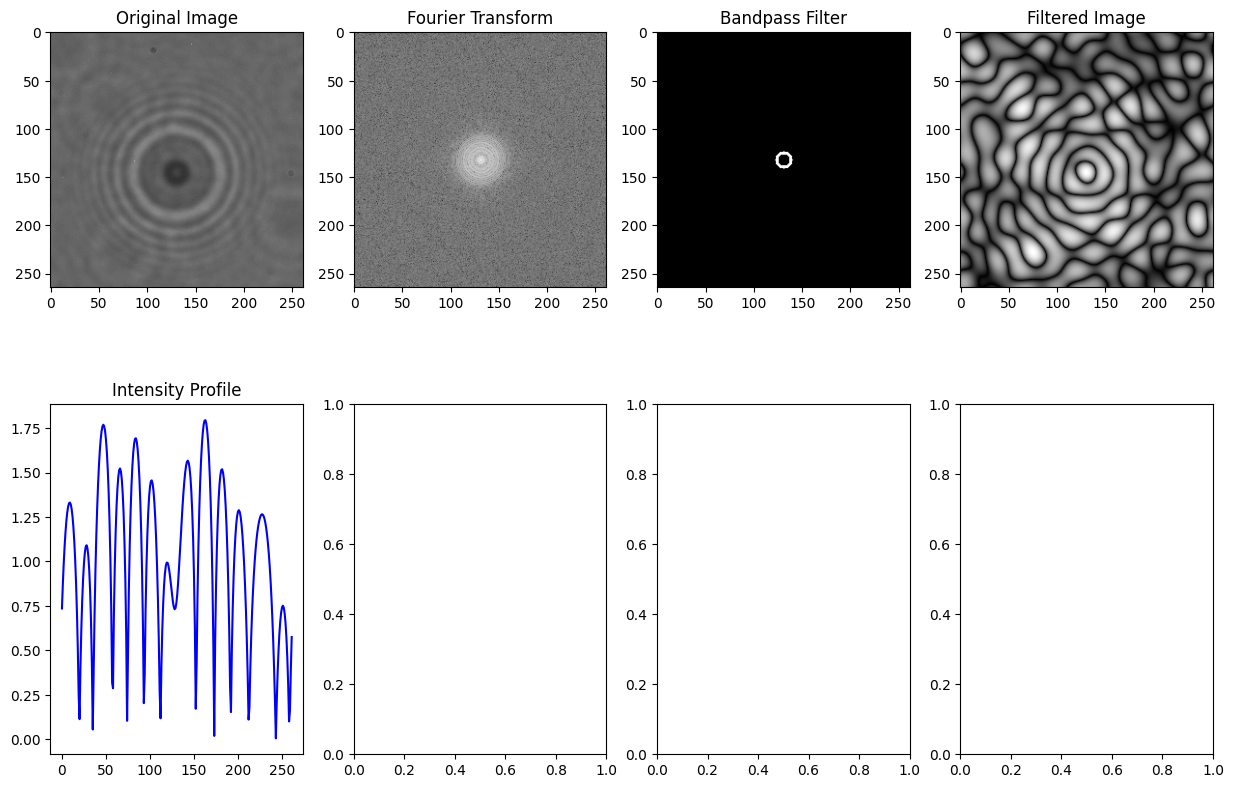

In [18]:
test_values = ['1','2','3','4','5','6','7','8','9','10']
r_vals=[[3,7],[6,9]]
ring_index_values = [1, 2]  # List of ring_index values

for test, r_val, ring_index in itertools.product(test_values, r_vals, ring_index_values):
    try:
        # Test each combination
        params = {
            'r_in': r_val[0],
            'r_out': r_val[1],
            'ring_index': ring_index,
            'allowed_change': 1,
            'input_path': 'Tiffs_Validation',
            'input_tiff': f'Video{test}.tif',
            'output_base_path': f'Results_Validation/Video{test}'
        }
        # ring_search(**params)
        post_processing(**params)
    except Exception as e:
        print(f"Test failed for parameters: test={test}, r_in={r_val[0]}, r_out={r_val[1]}, ring_index={ring_index}")
        print(f"Error: {e}")
        continue

In [19]:
# test='4'
# input_path='Tiffs_Validation'
# input_tiff=f'Video{test}.tif'
# # brightness=image_background_brightness(get_first_png(input_tiff, input_path))
# params={
#     'r_in':3,
#     'r_out':7,
#     'ring_index':1,
#     'allowed_change':1,
#     'input_path':input_path,
#     'input_tiff':input_tiff,
#     'output_base_path':f'Results_Validation/Video{test}'
# }

# print(params)
# ring_search(**params)
# post_processing(**params)